#Part 4

In [17]:
from google.colab import drive
drive.mount('/content/drive') # access drive



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
'''
Load the flower102 test dataset

'''

from torchvision.datasets import Flowers102


data_root = '/content/drive/MyDrive/flowers102/flowers102'


# Load the test dataset properly

test = Flowers102(
    root=data_root,
    split='test',       # only load test split
    download=False      # already downloaded
)



In [34]:
class GradCAM:
    """
    Grad-CAM (Gradient-weighted Class Activation Mapping) implementation for CNN-based models.

    Grad-CAM generates a heatmap highlighting the regions of an input image
    that are most influential for the model's prediction for a given class.

    Attributes:
        model (torch.nn.Module): The CNN model for which Grad-CAM is computed.
        target_layer (torch.nn.Module): The convolutional layer on which to compute Grad-CAM.
        activations (torch.Tensor or None): Saved activations from the target layer during the forward pass.
        gradients (torch.Tensor or None): Saved gradients from the target layer during the backward pass.

    Methods:
        save_activations(module, input, output):
            Hook function to store forward activations from the target layer.
        save_gradients(module, grad_input, grad_output):
            Hook function to store backward gradients from the target layer.
        generate(input_tensor, class_idx):
            Generates the Grad-CAM heatmap for a given input and target class index.
    """

    def __init__(self, model, target_layer):
        """
        Initializes the GradCAM object and registers hooks on the target layer.

        Args:
            model (torch.nn.Module): The trained CNN model.
            target_layer (torch.nn.Module): The convolutional layer where Grad-CAM is applied.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register a hook to save activations during the forward pass
        target_layer.register_forward_hook(self.save_activations)

        # Register a hook to save gradients during the backward pass
        # `register_full_backward_hook` ensures compatibility with newer PyTorch versions
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """
        Hook function to save activations from the target layer during forward pass.

        Args:
            module (torch.nn.Module): The layer where the hook is registered.
            input (tuple of torch.Tensor): Input to the layer (unused here).
            output (torch.Tensor): Output from the layer; saved as activations.
        """
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """
        Hook function to save gradients from the target layer during backward pass.

        Args:
            module (torch.nn.Module): The layer where the hook is registered.
            grad_input (tuple of torch.Tensor): Gradients w.r.t. layer inputs (unused here).
            grad_output (tuple of torch.Tensor): Gradients w.r.t. layer outputs; saved here.
        """
        # grad_output is a tuple; we take the first element as the gradient
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        """
        Generates a Grad-CAM heatmap for a given input and target class.

        Args:
            input_tensor (torch.Tensor): Input image tensor of shape [1, C, H, W] with gradients enabled.
            class_idx (int): Target class index for which to compute Grad-CAM.

        Returns:
            np.ndarray: 2D heatmap of shape [H, W], normalized to [0, 1].
        """
        # Clear any existing gradients
        self.model.zero_grad()

        # Forward pass: compute model outputs
        outputs = self.model(input_tensor)

        # Select the score corresponding to the target class
        score = outputs[:, class_idx]

        # Backward pass: compute gradients of score w.r.t. activations
        score.backward()

        # Global average pooling of gradients across spatial dimensions
        # This gives the "importance weight" for each channel
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted sum of activations using the computed weights
        # This produces the raw class activation map
        cam = (weights * self.activations).sum(dim=1)

        # Apply ReLU to keep only positive influences
        cam = torch.relu(cam)

        # Normalize CAM to [0, 1] for visualization
        cam = cam - cam.min()
        cam = cam / cam.max()

        # Remove batch/channel dimensions and convert to NumPy
        return cam.squeeze().detach().cpu().numpy()


In [35]:
#!pip install torchcam
#from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [36]:
import torch
import torchvision.models as models


model = models.resnet50(pretrained=False)

# we load the model again just like in previous sessions
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 102)

# Load your trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/flowers102_resnet50_best.pt'))
model.eval()  # set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:

target_layer = model.layer4[-1].conv3  # last conv layer in last block

# Initialize Grad-CAM with the last conv layer
gcam = GradCAM(model, target_layer)  # for ResNet


In [38]:
from torchvision import transforms

# select one random image
image, label = test[0]

# convert PIL image to tensor and add batch dimension
to_tensor = transforms.ToTensor()
input_tensor = to_tensor(image).unsqueeze(0)  # expected shape: [1, C, H, W]



In [39]:
import torch

 #Enable gradients for Grad-CAM
input_tensor.requires_grad = True

#Compute the model's raw output (logits) for the input image.
# outputs will have shape [1, 102] for Flowers102, with each element
# represent the unnormalized score for each class.
outputs = model(input_tensor)
# Find the index of the highest scoring class along the class dimension.
pred_class = outputs.argmax(dim=1).item()

print(f"True label: {label}") # ground truth and prediction
print(f"Predicted label: {pred_class}")


True label: 0
Predicted label: 19


In [40]:
# Target layer for Grad-CAM (last convolutional block)
target_layer = model.layer4[-1]
# initialize gradcam
gradcam = GradCAM(model, target_layer)

# returns a 2D numpy array of shape [H, W] normalized to [0, 1] which highlights regions that influenced the model's decision.
cam = gradcam.generate(
    input_tensor=input_tensor,
    class_idx=pred_class
)


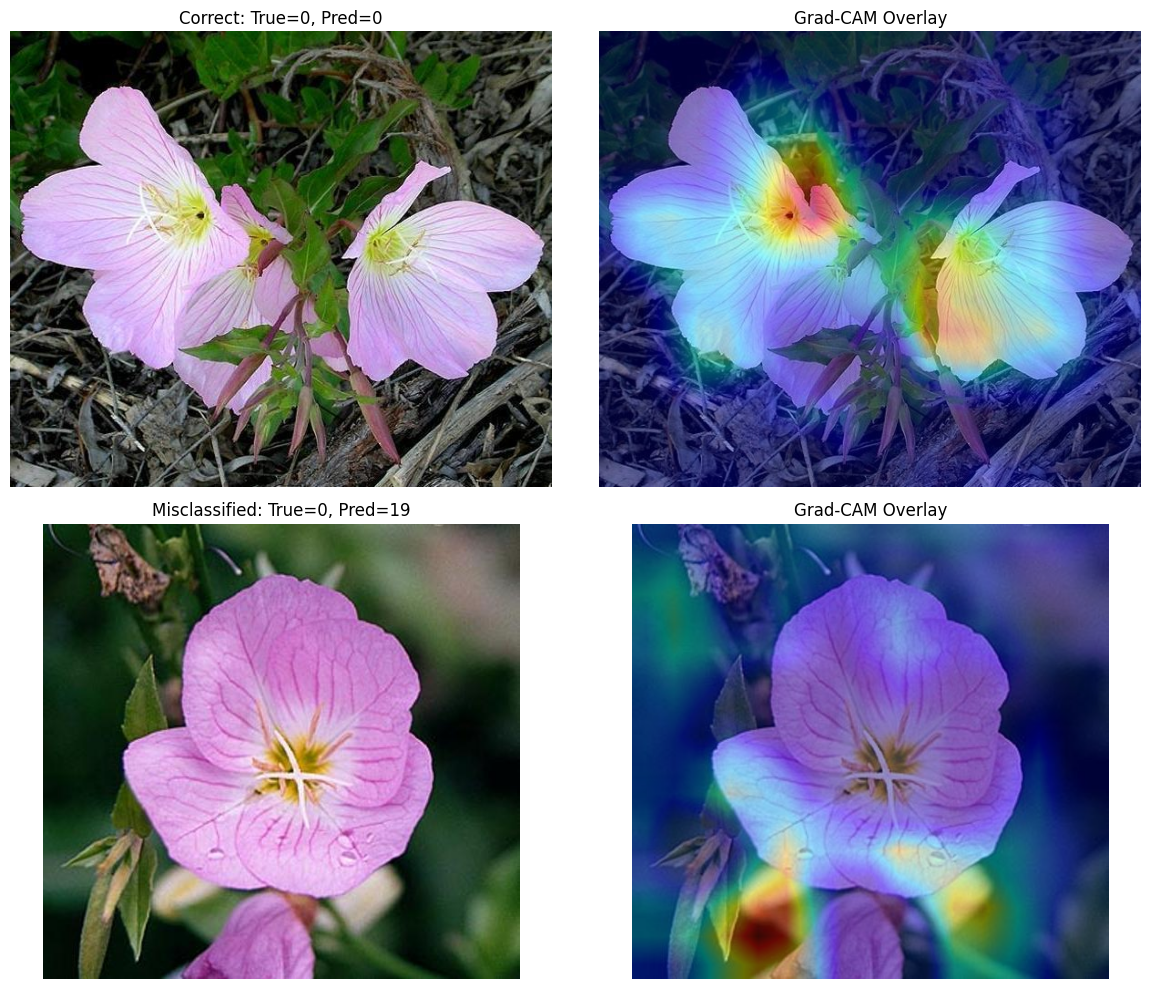

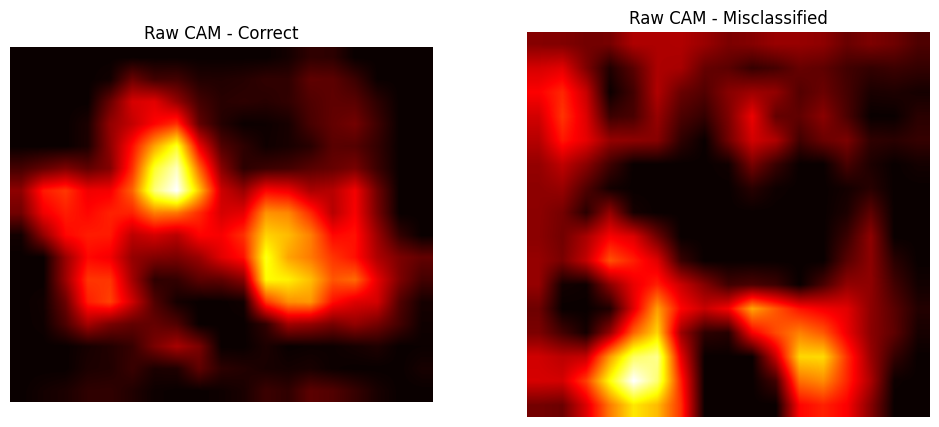

In [49]:
from torchvision import transforms
import cv2
import numpy as np

# to generate Grad-CAM overlay

def generate_cam_overlay(model, gradcam, image, class_idx):
    """
    Generate Grad-CAM heatmap and overlay for a single image.

    Args:
        model: PyTorch model.
        gradcam: GradCAM object with hooks on target layer.
        image: PIL Image.
        class_idx: Class index for which to compute Grad-CAM.

    Returns:
        cam_resized: 2D numpy array of CAM values (resized to image).
        overlay_rgb: Image overlay (CAM + original) in RGB for matplotlib.
    """
    # Convert PIL to tensor and add batch dimension
    to_tensor = transforms.ToTensor()
    input_tensor = to_tensor(image).unsqueeze(0)
    input_tensor.requires_grad = True

    # Generate Grad-CAM
    cam = gradcam.generate(input_tensor, class_idx)

    # Convert to numpy and resize to original image size
    img_np = np.array(image)
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Convert heatmap to RGB for matplotlib
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    overlay_rgb = cv2.addWeighted(img_np, 0.6, heatmap_rgb, 0.4, 0)

    return cam_resized, overlay_rgb



# Find one correctly classified sample

for i in range(len(test)):
    img, lbl = test[i]
    inp = transforms.ToTensor()(img).unsqueeze(0)
    pred = model(inp).argmax(dim=1).item()
    if pred == lbl:
        correct_image, correct_label, correct_pred = img, lbl, pred
        break


# Find one misclassified sample
for i in range(len(test)):
    img, lbl = test[i]
    inp = transforms.ToTensor()(img).unsqueeze(0)
    pred = model(inp).argmax(dim=1).item()
    if pred != lbl:
        mis_image, mis_label, mis_pred = img, lbl, pred
        break


# Generate Grad-CAMs
target_layer = model.layer4[-1]  # Last conv block
gradcam = GradCAM(model, target_layer)

# Correct sample
cam_correct, overlay_correct = generate_cam_overlay(model, gradcam, correct_image, correct_pred)

# Misclassified sample
cam_mis, overlay_mis = generate_cam_overlay(model, gradcam, mis_image, mis_pred)


# Plot visualizations

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Correctly classified
axes[0,0].imshow(correct_image)
axes[0,0].set_title(f"Correct: True={correct_label}, Pred={correct_pred}")
axes[0,0].axis('off')

axes[0,1].imshow(overlay_correct)
axes[0,1].set_title("Grad-CAM Overlay")
axes[0,1].axis('off')

# Misclassified
axes[1,0].imshow(mis_image)
axes[1,0].set_title(f"Misclassified: True={mis_label}, Pred={mis_pred}")
axes[1,0].axis('off')

axes[1,1].imshow(overlay_mis)
axes[1,1].set_title("Grad-CAM Overlay")
axes[1,1].axis('off')

plt.tight_layout()
plt.show()


# show raw CAM heatmap for more insight
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].imshow(cam_correct, cmap='hot')
axes[0].set_title("Raw CAM - Correct")
axes[0].axis('off')

axes[1].imshow(cam_mis, cmap='hot')
axes[1].set_title("Raw CAM - Misclassified")
axes[1].axis('off')
plt.show()


#Discussion

From what we can see, the correct classified region which is the color red, yellow part where it has some highlights on the center region of flowers, which means it did focus on some relevant features. For misclassified samples, we can see that the red, yellow color part focuses more on background or leaves, while the flowers or center region are mostly ignored as in blue color intensities. From the raw cam, we can see the correct classified intensities, it is focused in the center which is the flower part, where it look bright. For misclassified raw cam , the center looks black or dark, and the brught part is not on center but rather towards bottom background, which explains the misclassification.

#Concerning patterns

Model sometimes still relies on background or edges. Even correct predictions may sometimes rely on background, indicating potential fragility. The misclassification obviously highlights the issue.

